In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quilt
from quilt.data.elijahc import ripc

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

In [2]:
df = ripc.rel_fc()
pop_df = ripc.population_fc_stats()

In [3]:
df.head()

Name  Molecular_Weight sample_id  log2_fc  \
0             Oxaloacetic acid         132.00542        1A      0.0   
1             Oxaloacetic acid         132.00594        1A      0.0   
2                  Citric acid         192.02667        1A      0.0   
3  Dimethylphosphinic fluoride          96.01339        1A      0.0   
4      alpha-Ketoglutaric acid         146.02116        1A      0.0   

   patient_id  min  
0           1    0  
1           1    0  
2           1    0  
3           1    0  
4           1    0

In [4]:
pop_df.tail()

min  Molecular_Weight  log2fc_mean  log2fc_var   p-value
726485   60         268.20519     0.094736    0.812804  0.569362
726486   60         190.17731    -0.092935    0.587453  0.511858
726487   60         150.14178    -0.099776    1.926829  0.696683
726488   60         568.38420    -0.024295    0.092641  0.665231
726489   60         268.20540    -0.367258    0.681297  0.021178

In [7]:
name_df = df[['Molecular_Weight','min','Name']].drop_duplicates('Molecular_Weight')
volc_df = pop_df.merge(name_df,how='left',on=['min','Molecular_Weight'])
print(len(volc_df))
volc_df['log10p-value'] = -np.log10(volc_df['p-value'].values)
volc_df.tail()

726490


min  Molecular_Weight  log2fc_mean  log2fc_var   p-value Name  \
726485   60         268.20519     0.094736    0.812804  0.569362  NaN   
726486   60         190.17731    -0.092935    0.587453  0.511858  NaN   
726487   60         150.14178    -0.099776    1.926829  0.696683  NaN   
726488   60         568.38420    -0.024295    0.092641  0.665231  NaN   
726489   60         268.20540    -0.367258    0.681297  0.021178  NaN   

        log10p-value  
726485      0.244612  
726486      0.290851  
726487      0.156965  
726488      0.177027  
726489      1.674123

In [8]:
volc_df.describe()

min  Molecular_Weight    log2fc_mean     log2fc_var  \
count  726490.000000      726490.00000  726490.000000  726490.000000   
mean       18.500000         386.84793      -0.051770       0.892669   
std        19.293795         267.83100       0.276223       1.530448   
min         0.000000          65.01201      -5.417731       0.000000   
25%         4.000000         181.07512      -0.110939       0.149244   
50%         9.000000         308.03712      -0.001621       0.458249   
75%        30.000000         543.33509       0.059396       1.029739   
max        60.000000        2317.54647       5.644844      71.344216   

            p-value  log10p-value  
count  6.538410e+05  6.538410e+05  
mean   4.422730e-01  7.165256e-01  
std    3.035675e-01  1.192933e+00  
min    1.906702e-14  2.160647e-07  
25%    1.699784e-01  1.530580e-01  
50%    4.211045e-01  3.756102e-01  
75%    7.029785e-01  7.696062e-01  
max    9.999995e-01  1.371972e+01

In [9]:
len(volc_df.query('min == 2'))

72649

In [10]:
xrange = (-3,3)
yrange = (0,8)
TOOLS = 'pan,wheel_zoom,reset,hover,save'
timepoint = 10

In [14]:
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Spectral6, Plasma256

def volcano_plot(volc_df,timepoint=2,xrange=(-4,4),yrange=(0,8),tools='pan,wheel_zoom,reset,hover,save',output_path=None):
    source = ColumnDataSource(volc_df.query('min == '+str(timepoint)))
    
    mapper = log_cmap(field_name='Molecular_Weight', palette=Plasma256 ,low=min(volc_df['Molecular_Weight'].values) ,high=max(volc_df['Molecular_Weight'].values))
    p = bp.figure(tools=tools, x_range=xrange, y_range=yrange)
    p.hover.tooltips = [
        ("Name","@Name"),
        ("Molecular Weight", "@{Molecular_Weight}"),
        ("Log2 Fold Change", "@log2fc_mean"),
        ('p-value', '@{p-value}')
    ]
    
    p.circle("log2fc_mean","log10p-value", line_color=mapper, color=mapper, size=5,source=source)
    
    p.title.text = "Population Volcano plot @ {}min".format(timepoint)
    p.yaxis.axis_label = '-log10(p-value)'
    p.xaxis.axis_label = 'log2(FoldChange)'


    sig_stat_line = Span(location=-np.log10(0.05),
                            dimension='width', line_color='black',
                            line_dash='dashed', line_width=1)
    
    sig_stat_line3 = Span(location=-np.log10(0.001),
                            dimension='width', line_color='black',
                            line_dash='dashed', line_width=1)
    
    p.add_layout(sig_stat_line)
    p.add_layout(sig_stat_line3)

    zero_change = Span(location=0,
                            dimension='height', line_color='black',
                            line_dash='dashed', line_width=1)
    p.add_layout(zero_change)
    
    if output_path is not None:
        bp.output_file(os.path.join(output_path,"volcano{}.html".format(timepoint)), title="Log2 Fold Change @ {}min".format(timepoint))

    return p

In [15]:
bp.output_notebook()
p = volcano_plot(volc_df,timepoint=30,xrange=(-6,6),yrange=(0,12))
bp.show(p)

Loading BokehJS ...

# Make volcano plots for all timepoints

In [10]:
# for tp in [2,6,10]:
#     p = volcano_plot(volc_df,timepoint=tp,output_path="../viz/bokeh")
#     bp.show(p)
# p = volcano_plot(volc_df,output_path="../viz/bokeh")


In [21]:
df['Molecular_Weight_short'] = np.round(df['Molecular_Weight'].values,decimals=3)
df.query('Molecular_Weight_short == 468.349').head()

Name  Molecular_Weight sample_id  log2_fc  patient_id  min  \
35868   nan         468.34854        1A      0.0           1    0   
109683  nan         468.34854        2A      0.0           2    0   
183498  nan         468.34854        3A      0.0           3    0   
257313  nan         468.34854        4A      0.0           4    0   
331128  nan         468.34854        5A      0.0           5    0   

        Molecular_Weight_short  
35868                  468.349  
109683                 468.349  
183498                 468.349  
257313                 468.349  
331128                 468.349

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


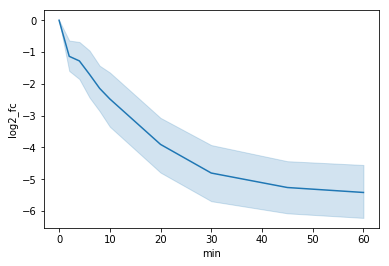

In [20]:
compound_w = 468.349
sns.lineplot(x='min',y='log2_fc',data=df.query('Molecular_Weight_short == 468.349'))

In [10]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage

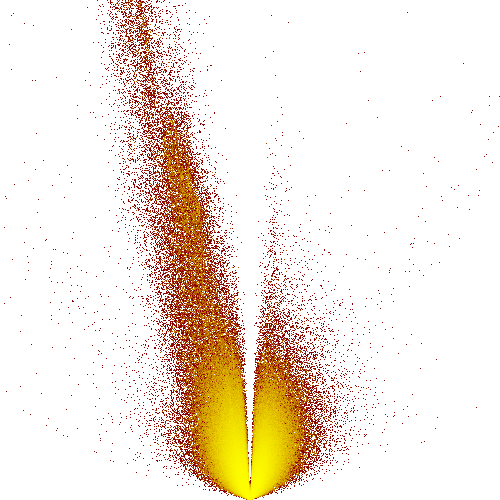

In [22]:
canvas = ds.Canvas(plot_width=500,plot_height=500, x_range=xrange,y_range=yrange)
agg = canvas.points(volc_df, 'log2fc_mean', 'log10p-value', agg=ds.count())
tf.shade(agg,cmap=["darkred","yellow"],how='eq_hist')

In [ ]:
bp.output_notebook()
TOOLS = 'pan,wheel_zoom,reset,tap'
# source = ColumnDataSource(df.query("min == 6"))
p = bp.figure(tools=TOOLS, x_range=xrange, y_range=yrange)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(pop_df, 'log2fc_mean', 'log10p-value', agg=ds.count())
    img = tf.shade(agg,cmap=["darkred","yellow"],how='eq_hist')
    return tf.dynspread(img, threshold=0.25)

InteractiveImage(p,image_callback)